In [25]:
import xarray as xr

folder_path = "../CAMELS_SW/output_data/"
file_name = "Vol_1979_2021_basin1673.nc"

streamflow_vol_1673 = xr.open_dataset(folder_path + file_name)
display(streamflow_vol_1673)

P =  xr.open_dataset("../CAMELS_SW/input_data/P_Camels_SW.nc")
display(P)

<xarray.Dataset>
Dimensions:         (Station_ID: 1, year: 60)
Coordinates:
    lon             (Station_ID) float64 ...
    lat             (Station_ID) float64 ...
  * Station_ID      (Station_ID) object '1673'
  * year            (year) int64 1961 1962 1963 1964 ... 2017 2018 2019 2020
Data variables:
    Vol_1Jan-30Sep  (Station_ID, year) float64 ...
    Vol_1Feb-30Sep  (Station_ID, year) float64 ...
    Vol_1Mar-30Sep  (Station_ID, year) float64 ...
    Vol_1Apr-30Sep  (Station_ID, year) float64 ...
    Vol_1May-30Sep  (Station_ID, year) float64 ...
    Vol_1Jun-30Sep  (Station_ID, year) float64 ...
    Vol_1Jul-30Sep  (Station_ID, year) float64 ...
    Vol_1Aug-30Sep  (Station_ID, year) float64 ...
    Vol_1Sep-30Sep  (Station_ID, year) float64 ...

<xarray.Dataset>
Dimensions:        (lle: 3, nday: 21915, station: 50)
Coordinates:
  * nday           (nday) datetime64[ns] 1961-01-01 1961-01-02 ... 2020-12-31
  * station        (station) object '1069' '1083' '1123' ... '751' '855' '97'
  * lle            (lle) object 'lon' 'lat' 'elev'
Data variables:
    precipitation  (station, nday) float64 ...
    LLE            (station, lle) float64 ...

In [26]:
import pandas as pd
import xarray as xr
import numpy as np

# Zielperioden definieren
target_periods = ['01/01-30/09', '01/02-30/09', '01/03-30/09', '01/04-30/09', '01/05-30/09',
                  '01/06-30/09', '01/07-30/09', '01/08-30/09', '01/09-30/09']

# Liste für Ergebnisse
results = []

for period in target_periods:
    # Angepasstes Format TT/MM verarbeiten
    start_day, start_month = map(int, period.split('-')[0].split('/'))
    end_day, end_month = map(int, period.split('-')[1].split('/'))

    # Funktion zur Filterung
    def is_within_period(dates):
        return ((dates.dt.month > start_month) | ((dates.dt.month == start_month) & (dates.dt.day >= start_day))) & \
               ((dates.dt.month < end_month) | ((dates.dt.month == end_month) & (dates.dt.day <= end_day)))

    # Erstelle die Maske
    mask = is_within_period(P['nday'])

    # Hole nur die Indizes, die True sind
    valid_dates = P['nday'].where(mask, drop=True)

    # Filtere die Daten für den Zeitraum
    period_data = P.sel(nday=valid_dates)

    # Gruppieren nach Jahr und summieren
    yearly_sums = period_data['precipitation'].groupby('nday.year').sum(dim='nday')

    # Ergebnisse sammeln
    results.append(yearly_sums)

# Ergebnisse zusammenführen
new_data_array = xr.concat(results, dim='target_period')
new_data_array = new_data_array.assign_coords(target_period=target_periods)

# Neue Variable im Dataset speichern
P['summed_precipitation'] = new_data_array

display(P)

<xarray.Dataset>
Dimensions:               (lle: 3, nday: 21915, station: 50, target_period: 9, year: 60)
Coordinates:
  * nday                  (nday) datetime64[ns] 1961-01-01 ... 2020-12-31
  * station               (station) object '1069' '1083' '1123' ... '855' '97'
  * lle                   (lle) object 'lon' 'lat' 'elev'
  * year                  (year) int64 1961 1962 1963 1964 ... 2018 2019 2020
  * target_period         (target_period) <U11 '01/01-30/09' ... '01/09-30/09'
Data variables:
    precipitation         (station, nday) float64 ...
    LLE                   (station, lle) float64 14.13 56.66 ... 62.82 365.6
    summed_precipitation  (target_period, station, year) float64 612.2 ... 66.95

In [27]:
station_id = "1673"  # Station-ID als String (falls IDs als Strings gespeichert sind)
catchment_data = P.sel(station=station_id)
catchment_data['summed_precipitation'] = catchment_data['summed_precipitation'] * 194.7 * 1000
# Ergebnis anzeigen
display(catchment_data)

<xarray.Dataset>
Dimensions:               (lle: 3, nday: 21915, target_period: 9, year: 60)
Coordinates:
  * nday                  (nday) datetime64[ns] 1961-01-01 ... 2020-12-31
    station               <U4 '1673'
  * lle                   (lle) object 'lon' 'lat' 'elev'
  * year                  (year) int64 1961 1962 1963 1964 ... 2018 2019 2020
  * target_period         (target_period) <U11 '01/01-30/09' ... '01/09-30/09'
Data variables:
    precipitation         (nday) float64 ...
    LLE                   (lle) float64 14.91 65.83 723.7
    summed_precipitation  (target_period, year) float64 1.833e+08 ... 3.736e+07

In [28]:
P_climatological_mean = catchment_data['summed_precipitation'].mean(dim='year')

# Ergebnis anzeigen
display(P_climatological_mean)
Q_climatological_mean = streamflow_vol_1673.mean(dim='year')

# Ergebnis anzeigen
display(Q_climatological_mean)

<xarray.DataArray 'summed_precipitation' (target_period: 9)>
array([1.39622526e+08, 1.17338502e+08, 1.00242375e+08, 8.34307286e+07,
       7.36638704e+07, 6.49552654e+07, 5.31974262e+07, 3.54374103e+07,
       1.91917556e+07])
Coordinates:
    station        <U4 '1673'
  * target_period  (target_period) <U11 '01/01-30/09' ... '01/09-30/09'

<xarray.Dataset>
Dimensions:         (Station_ID: 1)
Coordinates:
    lon             (Station_ID) float64 14.91
    lat             (Station_ID) float64 65.83
  * Station_ID      (Station_ID) object '1673'
Data variables:
    Vol_1Jan-30Sep  (Station_ID) float64 1.978e+08
    Vol_1Feb-30Sep  (Station_ID) float64 1.914e+08
    Vol_1Mar-30Sep  (Station_ID) float64 1.868e+08
    Vol_1Apr-30Sep  (Station_ID) float64 1.826e+08
    Vol_1May-30Sep  (Station_ID) float64 1.787e+08
    Vol_1Jun-30Sep  (Station_ID) float64 1.421e+08
    Vol_1Jul-30Sep  (Station_ID) float64 6.595e+07
    Vol_1Aug-30Sep  (Station_ID) float64 3.301e+07
    Vol_1Sep-30Sep  (Station_ID) float64 1.79e+07

In [29]:
# Berechnung des Anteils von P am Abfluss Q

# Sicherstellen, dass die Dimensionen passen (target_period oder Station_ID)
P_values = P_climatological_mean['summed_precipitation']  # Variable mit target_period
Q_values = Q_climatological_mean.to_array(dim='data_variables').squeeze()  # Alle Variablen in einem Array zusammenfassen, falls nötig

# Berechnung des Anteils (P/Q in Prozent)
percentage_contribution = (P_values / Q_values) * 100

# Neues DataArray mit den Ergebnissen erstellen
percentage_contribution.name = 'percentage_contribution'
percentage_contribution = percentage_contribution.to_dataset(name='percentage_contribution')

# Ergebnis anzeigen
print(percentage_contribution)


KeyError: 'summed_precipitation'

In [35]:
import xarray as xr 
import numpy as np

# Dateipfade
folder_path = "../CAMELS_SW/output_data/"
file_name = "Vol_1979_2021_basin1673.nc"

# Daten laden
streamflow_vol_1673 = xr.open_dataset(folder_path + file_name)  # Abflussdaten
P = xr.open_dataset("../CAMELS_SW/input_data/P_Camels_SW.nc")  # Niederschlagsdaten

# Zielperioden und zugehörige Data Variables definieren
target_periods = ['01/01-30/09', '01/02-30/09', '01/03-30/09', '01/04-30/09', '01/05-30/09',
                  '01/06-30/09', '01/07-30/09', '01/08-30/09', '01/09-30/09']
data_variables = ['Vol_1Jan-30Sep', 'Vol_1Feb-30Sep', 'Vol_1Mar-30Sep', 'Vol_1Apr-30Sep',
                  'Vol_1May-30Sep', 'Vol_1Jun-30Sep', 'Vol_1Jul-30Sep', 'Vol_1Aug-30Sep', 'Vol_1Sep-30Sep']

# Niederschlag summieren für jede Zielperiode
results = []
for period in target_periods:
    # Zielperiode extrahieren
    start_day, start_month = map(int, period.split('-')[0].split('/'))
    end_day, end_month = map(int, period.split('-')[1].split('/'))

    # Funktion zur Filterung von Daten innerhalb der Zielperiode
    def is_within_period(dates):
        return ((dates.dt.month > start_month) | ((dates.dt.month == start_month) & (dates.dt.day >= start_day))) & \
               ((dates.dt.month < end_month) | ((dates.dt.month == end_month) & (dates.dt.day <= end_day)))

    # Erstelle Maske und filtere Daten
    mask = is_within_period(P['nday'])
    valid_dates = P['nday'].where(mask, drop=True)
    period_data = P.sel(nday=valid_dates)

    # Gruppieren nach Jahr und Summieren des Niederschlags
    yearly_sums = period_data['precipitation'].groupby('nday.year').sum(dim='nday')
    results.append(yearly_sums)

# Zusammenführen der Ergebnisse und Hinzufügen zu Dataset
summed_precipitation = xr.concat(results, dim='target_period')
summed_precipitation = summed_precipitation.assign_coords(target_period=target_periods)
P['summed_precipitation'] = summed_precipitation

# Daten für Station 1673 extrahieren und Volumen berechnen
station_id = "1673"
catchment_data = P.sel(station=station_id)
catchment_data['summed_precipitation'] = catchment_data['summed_precipitation'] * 194.7 * 1000  # Flächenfaktor

# Klimatologischer Mittelwert für Niederschlag berechnen
P_climatological_mean = catchment_data['summed_precipitation'].mean(dim='year')

# Anteil pro Zielperiode berechnen
percentage_contributions = []
for target_period, data_variable in zip(target_periods, data_variables):
    # Hole die Werte für die entsprechende target_period und Data Variable
    P_value = P_climatological_mean.sel(target_period=target_period).item()  # Einzelwert extrahieren
    Q_value = Q_climatological_mean[data_variable].item()  # Einzelwert extrahieren
    
    # Berechne den Anteil (P/Q in Prozent)
    percentage = (P_value / Q_value) * 100
    percentage_contributions.append(percentage)

# Konvertiere die Liste in ein eindimensionales Array
percentage_contributions = np.array(percentage_contributions)

# Erstelle ein DataArray mit einer Dimension
percentage_contributions = xr.DataArray(
    data=percentage_contributions,
    dims=["target_period"],
    coords={"target_period": target_periods},
    name="percentage_contribution"
)

# Ergebnis speichern und anzeigen
percentage_contributions = percentage_contributions.to_dataset(name='percentage_contribution')
display(percentage_contributions)


<xarray.Dataset>
Dimensions:                  (target_period: 9)
Coordinates:
  * target_period            (target_period) <U11 '01/01-30/09' ... '01/09-30/09'
Data variables:
    percentage_contribution  (target_period) float64 70.58 61.32 ... 107.4 107.2

In [39]:
import xarray as xr
import numpy as np

# Pfade und Basins
folder_path = "../CAMELS_SW/output_data/"
P_file_path = "../CAMELS_SW/input_data/P_Camels_SW.nc"

basin_ids = ['591', '1083', '1341', '1403', '1537', '1673', '1780']
basin_areas = {'591': 1718, '1083': 65, '1341': 1110, '1403': 1174, '1537': 428, '1673': 195, '1780': 391}  # Flächen in km²

# Zielperioden und zugehörige Data Variables definieren
target_periods = ['01/01-30/09', '01/02-30/09', '01/03-30/09', '01/04-30/09', '01/05-30/09',
                  '01/06-30/09', '01/07-30/09', '01/08-30/09', '01/09-30/09']
data_variables = ['Vol_1Jan-30Sep', 'Vol_1Feb-30Sep', 'Vol_1Mar-30Sep', 'Vol_1Apr-30Sep',
                  'Vol_1May-30Sep', 'Vol_1Jun-30Sep', 'Vol_1Jul-30Sep', 'Vol_1Aug-30Sep', 'Vol_1Sep-30Sep']

# Niederschlagsdaten laden
P = xr.open_dataset(P_file_path)

# Ergebnisse für alle Basins speichern
all_basin_results = []

for basin_id in basin_ids:
    # Streamflow-Daten für das aktuelle Basin laden
    streamflow_file = f"{folder_path}Vol_1979_2021_basin{basin_id}.nc"
    streamflow_vol = xr.open_dataset(streamflow_file)

    # Fläche des Basins (in m²)
    area = basin_areas[basin_id] * 1e6  # Umrechnung von km² in m²

    # Niederschlag summieren für jede Zielperiode
    results = []
    for period in target_periods:
        # Zielperiode extrahieren
        start_day, start_month = map(int, period.split('-')[0].split('/'))
        end_day, end_month = map(int, period.split('-')[1].split('/'))

        # Funktion zur Filterung von Daten innerhalb der Zielperiode
        def is_within_period(dates):
            return ((dates.dt.month > start_month) | ((dates.dt.month == start_month) & (dates.dt.day >= start_day))) & \
                   ((dates.dt.month < end_month) | ((dates.dt.month == end_month) & (dates.dt.day <= end_day)))

        # Erstelle Maske und filtere Daten
        mask = is_within_period(P['nday'])
        valid_dates = P['nday'].where(mask, drop=True)
        period_data = P.sel(nday=valid_dates)

        # Gruppieren nach Jahr und Summieren des Niederschlags
        yearly_sums = period_data['precipitation'].groupby('nday.year').sum(dim='nday')
        results.append(yearly_sums)

    # Zusammenführen der Ergebnisse und Hinzufügen zu Dataset
    summed_precipitation = xr.concat(results, dim='target_period')
    summed_precipitation = summed_precipitation.assign_coords(target_period=target_periods)
    P['summed_precipitation'] = summed_precipitation

    # Daten für das aktuelle Basin extrahieren und Volumen berechnen
    catchment_data = P.sel(station=basin_id)
    catchment_data['summed_precipitation'] = catchment_data['summed_precipitation'] * area * 0.001  # Volumen in m³

    # Klimatologischer Mittelwert für Niederschlag berechnen
    P_climatological_mean = catchment_data['summed_precipitation'].mean(dim='year')

    # Klimatologischer Mittelwert für Abfluss berechnen und den Anteil pro Zielperiode
    percentage_contributions = []
    for target_period, data_variable in zip(target_periods, data_variables):
        # Hole die Werte für die entsprechende target_period und Data Variable
        P_value = P_climatological_mean.sel(target_period=target_period).item()  # Einzelwert extrahieren
        Q_value = streamflow_vol[data_variable].mean(dim='year').item()  # Einzelwert extrahieren

        # Berechne den Anteil (P/Q in Prozent)
        percentage = (P_value / Q_value) * 100
        percentage_contributions.append(percentage)

    # Konvertiere die Liste in ein DataArray
    percentage_contributions = xr.DataArray(
        data=percentage_contributions,
        dims=["target_period"],
        coords={"target_period": target_periods},
        name=f"percentage_contribution_{basin_id}"
    )

    # Speichere die Ergebnisse für das Basin
    all_basin_results.append(percentage_contributions)

# Zusammenführen aller Ergebnisse in ein Dataset
final_dataset = xr.merge(all_basin_results)

# Ergebnis speichern und anzeigen
final_dataset.to_netcdf("percentage_contributions_all_basins.nc")
display(final_dataset)



<xarray.Dataset>
Dimensions:                       (target_period: 9)
Coordinates:
  * target_period                 (target_period) <U11 '01/01-30/09' ... '01/09-30/09'
Data variables:
    percentage_contribution_591   (target_period) float64 90.2 80.36 ... 110.3
    percentage_contribution_1083  (target_period) float64 113.7 102.8 ... 162.6
    percentage_contribution_1341  (target_period) float64 86.79 78.27 ... 134.8
    percentage_contribution_1403  (target_period) float64 119.6 112.2 ... 131.8
    percentage_contribution_1537  (target_period) float64 74.83 64.86 ... 107.1
    percentage_contribution_1673  (target_period) float64 70.69 61.41 ... 107.4
    percentage_contribution_1780  (target_period) float64 140.3 134.5 ... 161.5

<xarray.Dataset>
Dimensions:         (Station_ID: 1, year: 60)
Coordinates:
    lon             (Station_ID) float64 ...
    lat             (Station_ID) float64 ...
  * Station_ID      (Station_ID) object '1780'
  * year            (year) int64 1961 1962 1963 1964 ... 2017 2018 2019 2020
Data variables:
    Vol_1Jan-30Sep  (Station_ID, year) float64 9.552e+07 1.005e+08 ... 1.493e+08
    Vol_1Feb-30Sep  (Station_ID, year) float64 9.334e+07 9.666e+07 ... 1.431e+08
    Vol_1Mar-30Sep  (Station_ID, year) float64 9.162e+07 9.35e+07 ... 1.38e+08
    Vol_1Apr-30Sep  (Station_ID, year) float64 8.974e+07 9.086e+07 ... 1.334e+08
    Vol_1May-30Sep  (Station_ID, year) float64 8.801e+07 8.808e+07 ... 1.291e+08
    Vol_1Jun-30Sep  (Station_ID, year) float64 6.802e+07 5.897e+07 ... 1.116e+08
    Vol_1Jul-30Sep  (Station_ID, year) float64 5.035e+07 3.173e+07 ... 5.303e+07
    Vol_1Aug-30Sep  (Station_ID, year) float64 3.116e+07 2.096e+07 ... 2.845e+07
    Vol_1Sep-30Sep  (Station_ID, year) float64 7.975e+06 1.134e+07 ... 1.173e+07

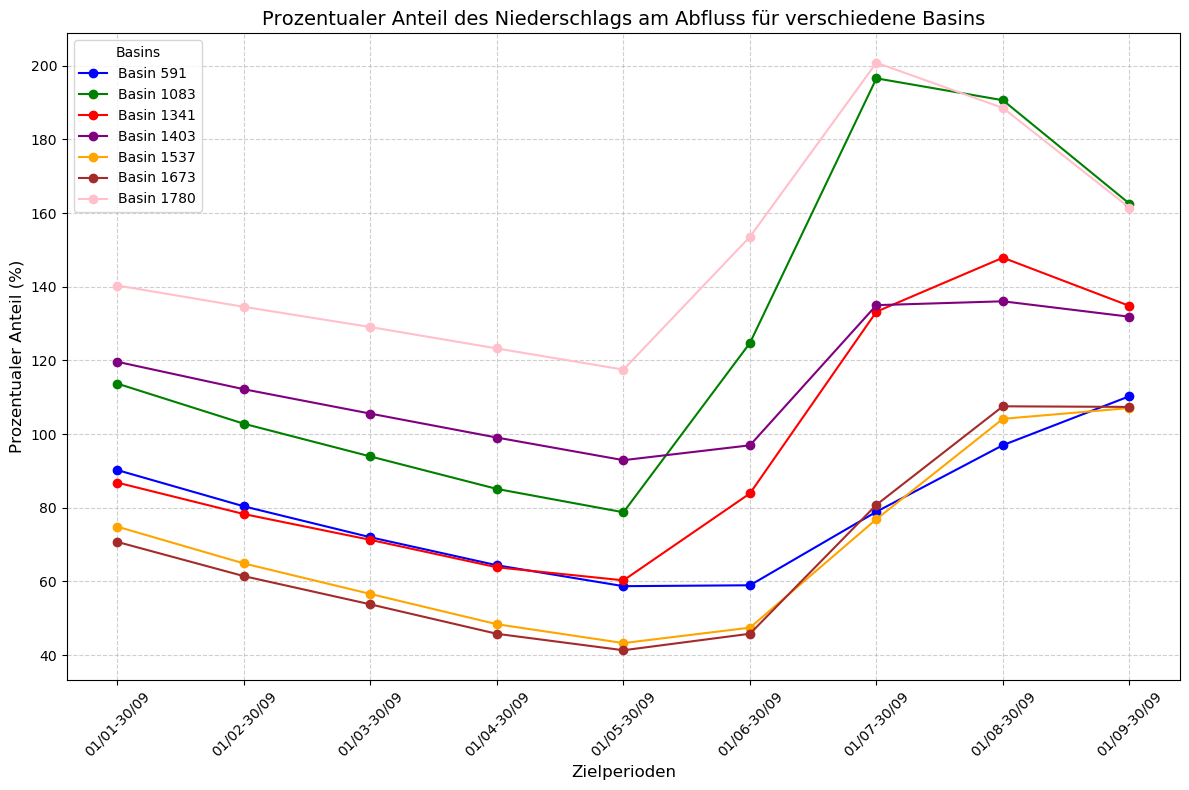

In [38]:
import matplotlib.pyplot as plt

# Lade das berechnete Dataset (falls nötig)
# final_dataset = xr.open_dataset("percentage_contributions_all_basins.nc")

# Farben und Stile für die Basins
basin_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Erstelle den Plot
plt.figure(figsize=(12, 8))
for basin_id, color in zip(basin_ids, basin_colors):
    # Hole die prozentualen Anteile für das aktuelle Basin
    contributions = final_dataset[f"percentage_contribution_{basin_id}"]
    
    # Plotten der Daten
    plt.plot(
        contributions['target_period'], 
        contributions.values, 
        label=f"Basin {basin_id}", 
        marker='o', 
        color=color
    )

# Plot-Details
plt.title("Prozentualer Anteil des Niederschlags am Abfluss für verschiedene Basins", fontsize=14)
plt.xlabel("Zielperioden", fontsize=12)
plt.ylabel("Prozentualer Anteil (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Basins", fontsize=10)
plt.tight_layout()

# Plot anzeigen
plt.show()
